In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

C:\Users\Triton Neo 16\diffusion-teset\venv\lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\Triton Neo 16\diffusion-teset\venv\lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Using device: cuda


100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 8308365.95it/s]


Extracting mnist/MNIST\raw\train-images-idx3-ubyte.gz to mnist/MNIST\raw



100%|██████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 28576478.85it/s]


Extracting mnist/MNIST\raw\train-labels-idx1-ubyte.gz to mnist/MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 8120941.69it/s]


Extracting mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to mnist/MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist/MNIST\raw

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([9, 0, 7, 3, 9, 6, 5, 9])


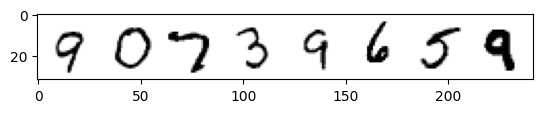

In [2]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())
# dataset = torchvision.datasets.FashionMNIST(root="fashion_mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')


C:\Users\Triton Neo 16\diffusion-teset\venv\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\Triton Neo 16\diffusion-teset\venv\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


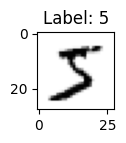

torch.Size([28, 28])


In [3]:
image, label = dataset.train_data[0], dataset.train_labels[0]

# Reshape the image to match the expected dimensions
image = image.reshape(28, 28)

# Plot the image using matplotlib
fig, ax = plt.subplots(1,1, figsize=(1, 1))
ax.imshow(image, cmap="Greys")
ax.set_title(f"Label: {label}")
plt.show()
print(image.shape)

In [4]:
def corrupt(x, amount):
  noise = torch.rand_like(x)
  amount = amount.view(-1,1,1,1)
  return (1-amount) * x + amount * noise

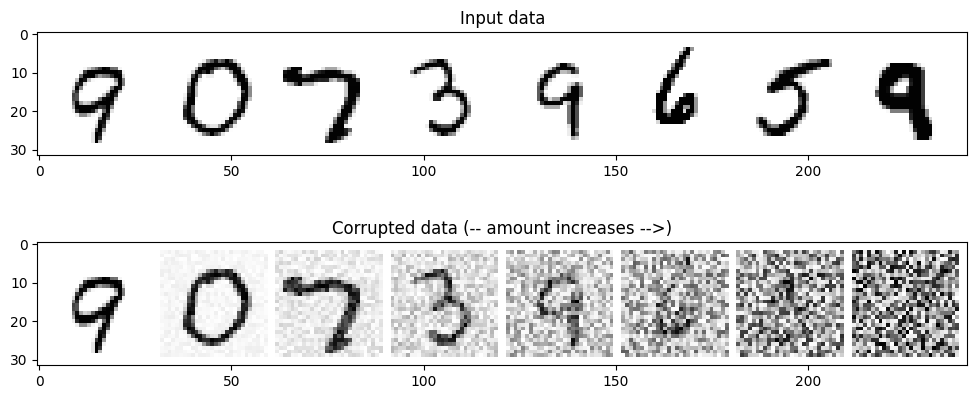

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')


In [6]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:
                h.append(x)
                x = self.downscale(x)
        for i, l in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x += h.pop()
            x = self.act(l(x))
        return x

In [7]:
# check shape
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [8]:
# calc parameter number
sum([p.numel() for p in net.parameters()])

309057

Finished epoch 0. Average loss for this epoch: 0.025131
Finished epoch 1. Average loss for this epoch: 0.019450
Finished epoch 2. Average loss for this epoch: 0.018083
Finished epoch 3. Average loss for this epoch: 0.017327
Finished epoch 4. Average loss for this epoch: 0.016886


(0.0, 0.1)

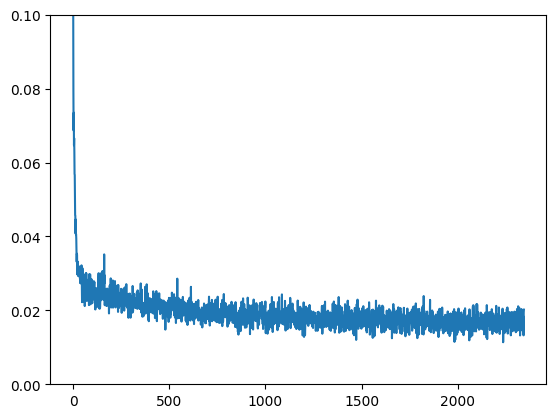

In [9]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

n_epochs = 5

net = BasicUNet()
net.to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []

for epoch in range(n_epochs):
    for x, y in train_dataloader:
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)
        pred = net(noisy_x)
        loss = loss_fn(pred, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

plt.plot(losses)
plt.ylim(0, .1)


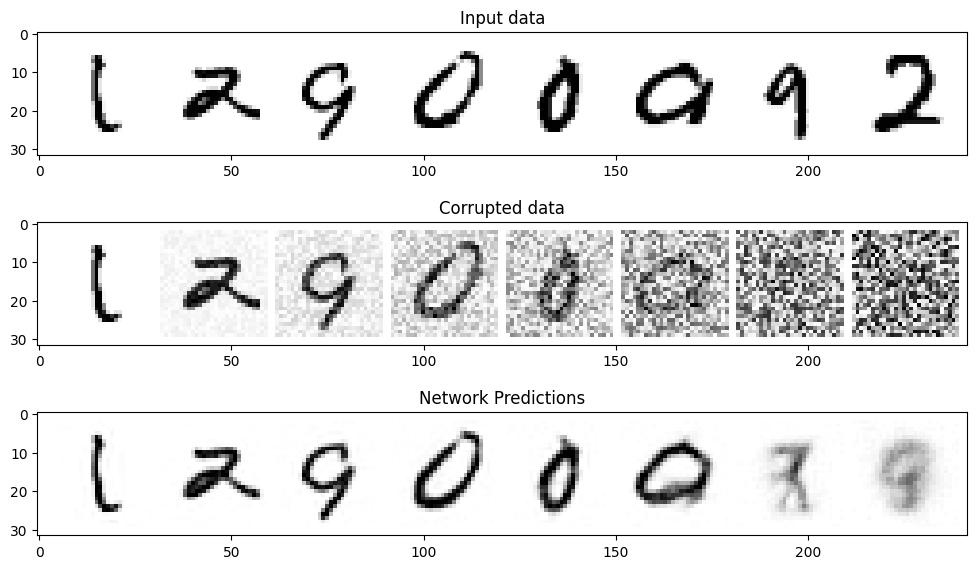

In [10]:
x, y = next(iter(train_dataloader))
x = x[:8]

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')


axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys')

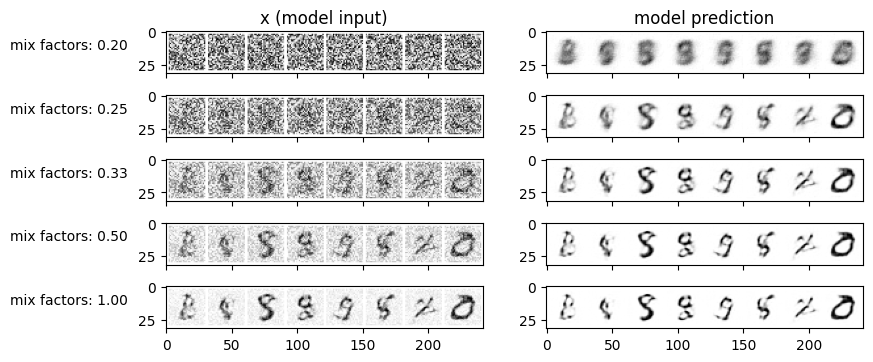

In [11]:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device)
step_history = [x.detach().cpu()]
pred_output_history = []
mix_factors = []
for i in range(n_steps):
    with torch.no_grad():
        pred = net(x)
    pred_output_history.append(pred.detach().cpu())
    mix_factor = 1 / (n_steps - i)
    mix_factors.append(mix_factor)
    x = x * (1 - mix_factor) + pred * mix_factor
    step_history.append(x.detach().cpu())

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title('x (model input)')
axs[0, 1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 0].set_ylabel(f"mix factors: {mix_factors[i]:.2f}", rotation=0, labelpad=50)
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

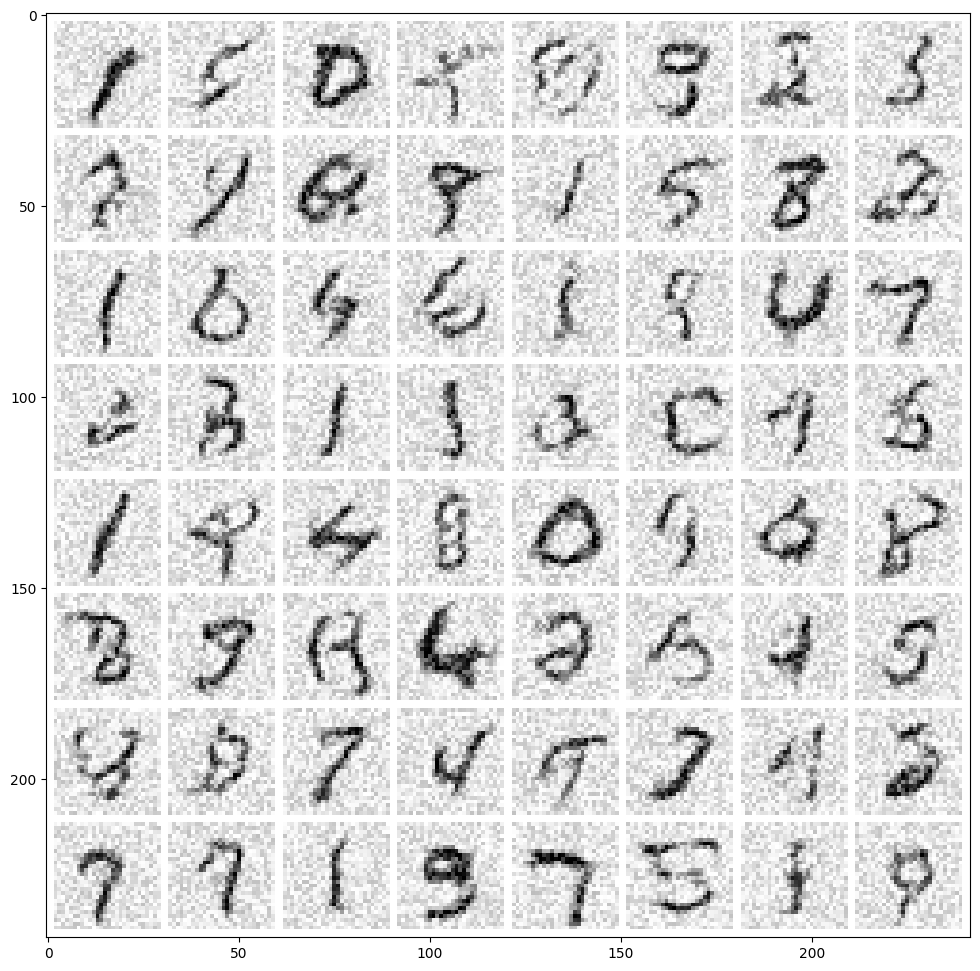

In [12]:
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i/n_steps))
    with torch.no_grad():
        pred = net(x)
    mix_factor = 1 / (n_steps - 1)
    x = x * (1 - mix_factor) + pred * mix_factor
    step_history.append(x.detach().cpu())

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

# UNet2DModel

In [13]:
UNet2DModel??

Init signature:
UNet2DModel(
    sample_size: Union[int, Tuple[int, int], NoneType] = None,
    in_channels: int = 3,
    out_channels: int = 3,
    center_input_sample: bool = False,
    time_embedding_type: str = 'positional',
    freq_shift: int = 0,
    flip_sin_to_cos: bool = True,
    down_block_types: Tuple[str] = ('DownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D'),
    up_block_types: Tuple[str] = ('AttnUpBlock2D', 'AttnUpBlock2D', 'AttnUpBlock2D', 'UpBlock2D'),
    block_out_channels: Tuple[int] = (224, 448, 672, 896),
    layers_per_block: int = 2,
    mid_block_scale_factor: float = 1,
    downsample_padding: int = 1,
    downsample_type: str = 'conv',
    upsample_type: str = 'conv',
    dropout: float = 0.0,
    act_fn: str = 'silu',
    attention_head_dim: Optional[int] = 8,
    norm_num_groups: int = 32,
    attn_norm_num_groups: Optional[int] = None,
    norm_eps: float = 1e-05,
    resnet_time_scale_shift: str = 'default',
    add_attention: bool =

In [14]:
model = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 64),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D"
    )
)
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleLis

In [15]:
sum([p.numel() for p in model.parameters()])

1707009

In [16]:
torch.numel?

Docstring:
numel(input) -> int

Returns the total number of elements in the :attr:`input` tensor.

Args:
    input (Tensor): the input tensor.

Example::

    >>> a = torch.randn(1, 2, 3, 4, 5)
    >>> torch.numel(a)
    120
    >>> a = torch.zeros(4,4)
    >>> torch.numel(a)
    16
Type:      builtin_function_or_method

C:\Users\Triton Neo 16\diffusion-teset\venv\lib\site-packages\diffusers\models\attention_processor.py:1244: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(


Finished epoch 0. Average loss for this epoch: 0.018766
Finished epoch 1. Average loss for this epoch: 0.012905
Finished epoch 2. Average loss for this epoch: 0.011740


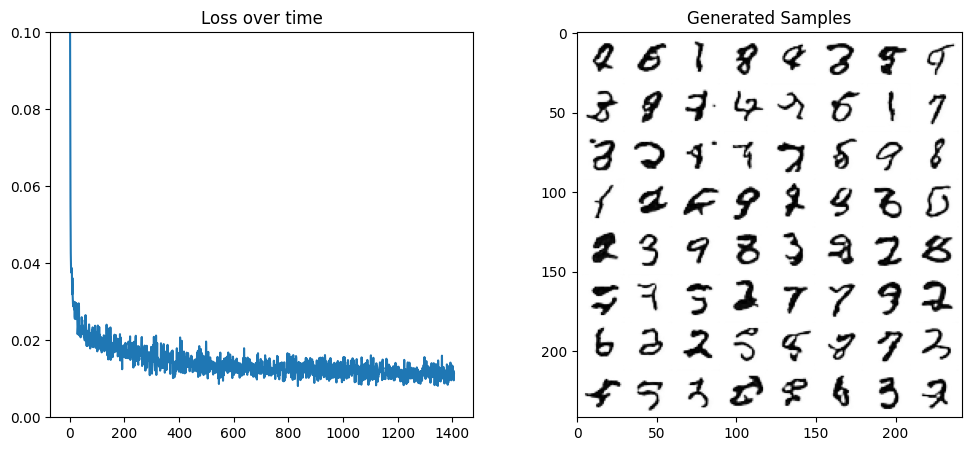

In [17]:
#@markdown Trying UNet2DModel instead of BasicUNet:

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');

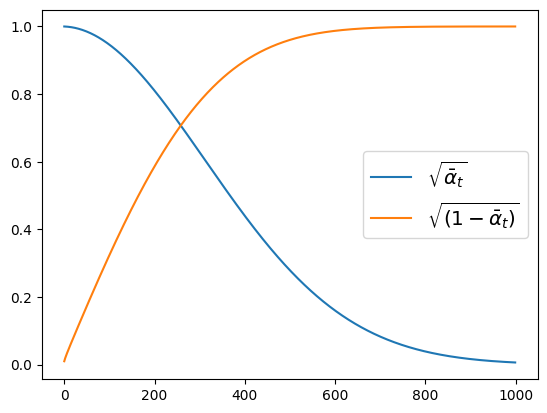

In [18]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** .5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1-noise_scheduler.alphas_cumprod.cpu()) ** .5, label=r"${\sqrt{(1 - \bar{\alpha}_t)}}$")
plt.legend(fontsize='x-large')

In [19]:
??noise_scheduler.add_noise

Signature:
noise_scheduler.add_noise(
    original_samples: torch.FloatTensor,
    noise: torch.FloatTensor,
    timesteps: torch.IntTensor,
) -> torch.FloatTensor
Docstring: <no docstring>
Source:   
    def add_noise(
        self,
        original_samples: torch.FloatTensor,
        noise: torch.FloatTensor,
        timesteps: torch.IntTensor,
    ) -> torch.FloatTensor:
        # Make sure alphas_cumprod and timestep have same device and dtype as original_samples
        # Move the self.alphas_cumprod to device to avoid redundant CPU to GPU data movement
        # for the subsequent add_noise calls
        self.alphas_cumprod = self.alphas_cumprod.to(device=original_samples.device)
        alphas_cumprod = self.alphas_cumprod.to(dtype=original_samples.dtype)
        timesteps = timesteps.to(original_samples.device)

        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()
        while len(sqrt_alpha_prod.shape) < len(original_s

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


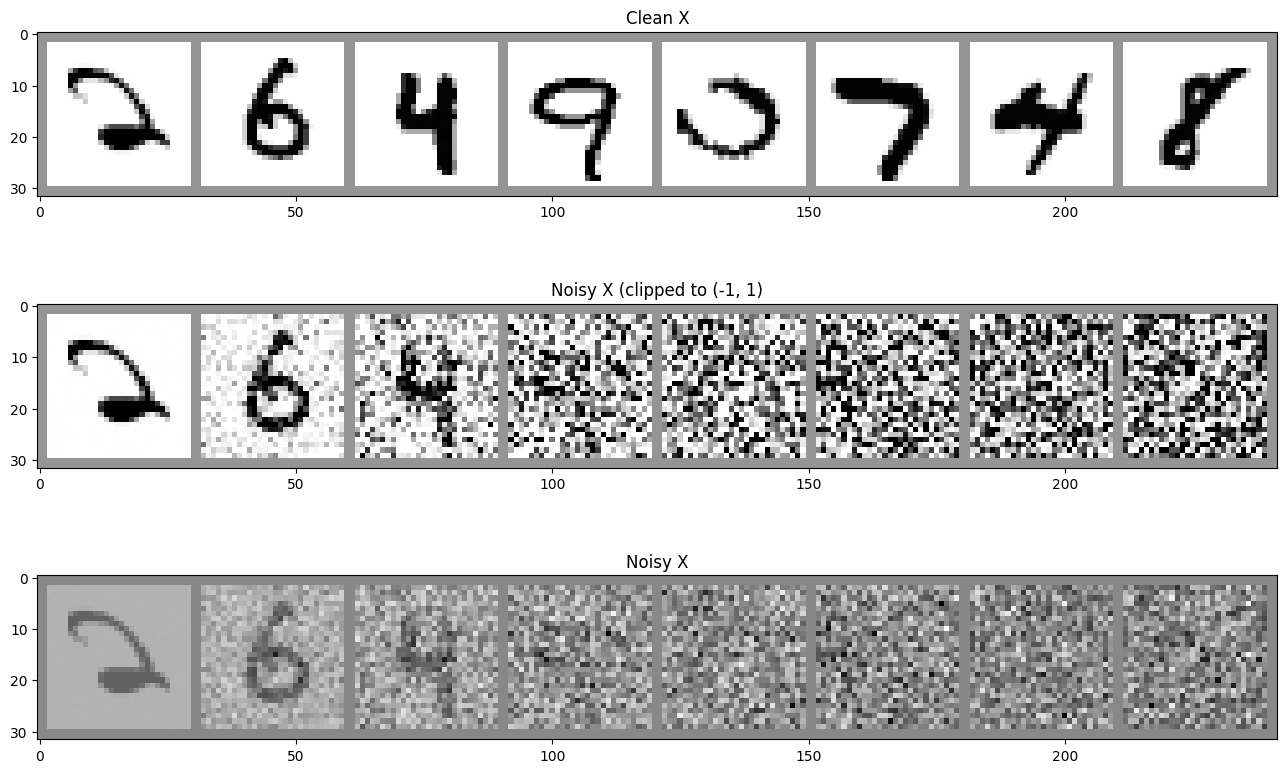

In [20]:
#@markdown visualize the DDPM noising process for different timesteps:

# Noise a batch of images to view the effect
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1. # Map to (-1, 1)
print('X shape', xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),  cmap='Greys')
axs[2].set_title('Noisy X');

In [34]:
noise = torch.randn_like(xb)
noisy_x = noise_scheduler.add_noise(xb, noise, timesteps)
noisy_x = noisy_x.to('cpu')
timesteps = timesteps.to('cpu')

model = model.to('cpu')
model_prediction = model(noisy_x, timesteps).sample
model_prediction = model_prediction.to('cpu')
noise = noise.to('cpu')
loss = nn.MSELoss(reduction="none")(model_prediction, noise)
loss_shape = loss.shape
loss_shape

torch.Size([8, 1, 28, 28])

In [35]:
print(f"model_prediction shape: {model_prediction.shape}")
print(f"noise shape: {noise.shape}")

model_prediction shape: torch.Size([8, 1, 28, 28])
noise shape: torch.Size([8, 1, 28, 28])
